---
title: "TTC Subway Delay Analysis"
author: "Omina Nematova"
date: "17 March 2025"
format:
  html:
    title-block-style: plain
    title-block-banner: false
  pdf:
    title-block-style: plain
    keep-tex: true

---

#### Project GitHub: https://github.com/omina26/TTC-Subway-Delay-Analysis

In [1]:
#| include: false
!pip install geopandas

In [2]:
#| include: false
!pip install openmeteo-requests

  Using cached openmeteo_requests-1.4.0-py3-none-any.whl.metadata (9.7 kB)
  Using cached openmeteo_sdk-1.20.0-py3-none-any.whl.metadata (935 bytes)
Using cached openmeteo_requests-1.4.0-py3-none-any.whl (6.0 kB)
Using cached openmeteo_sdk-1.20.0-py3-none-any.whl (15 kB)


In [3]:
#| include: false
!pip install requests-cache retry-requests numpy pandas 

  Using cached requests_cache-1.2.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached retry_requests-2.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached cattrs-24.1.3-py3-none-any.whl.metadata (8.4 kB)
  Using cached url_normalize-2.2.0-py3-none-any.whl.metadata (4.9 kB)
Using cached requests_cache-1.2.1-py3-none-any.whl (61 kB)
Using cached retry_requests-2.0.0-py3-none-any.whl (15 kB)
Using cached cattrs-24.1.3-py3-none-any.whl (66 kB)
Using cached url_normalize-2.2.0-py3-none-any.whl (14 kB)


In [4]:
#| include: false
!pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [5]:
#| include: false
import logging
logging.getLogger().setLevel(logging.ERROR)  # Suppress info/warning messages
import warnings
warnings.filterwarnings("ignore") 
import requests
from io import BytesIO
import pandas as pd
import geopandas as gpd
import time
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [6]:
#| include: false

# import merged_df from data folder (look at analysis.ipynb to see how merged_df was created)
merged_df = pd.read_csv("../data/merged_data.csv")

# Display first few rows of the dataset
print(merged_df.head())
print(merged_df.info())

         date   time     day   code  min_delay bound line  \
0  2024-01-01  07:57  Monday  TUNOA         12     N   YU   
1  2024-01-01  08:41  Monday  TUNOA          6     N   YU   
2  2024-01-01  08:42  Monday  TUNIP          6     N   YU   
3  2024-01-01  09:09  Monday  PUOPO          7     S   YU   
4  2024-01-01  09:17  Monday  PUOPO          6     S   YU   

                 station  hour  temperature  relative_humidity  \
0  SHEPPARD WEST STATION     7       -1.114           82.81025   
1       EGLINTON STATION     8       -1.614           81.20514   
2  SHEPPARD WEST STATION     8       -1.614           81.20514   
3       ST CLAIR STATION     9       -2.014           78.13702   
4     SUMMERHILL STATION     9       -2.014           78.13702   

   apparent_temperature  precipitation  rain  snowfall  snow_depth  \
0             -5.712741            0.1   0.0      0.07        0.02   
1             -6.188531            0.2   0.0      0.14        0.02   
2             -6.188531   

### Introduction

As businesses increasingly encourage employees to return to in-office work, reliable transportation is becoming more important than ever for commuters. Many workers rely on subway systems for their daily commutes. Subway delays can disrupt schedules, increase travel time uncertainty, and even influence long-term decisions about where people choose to live or work. While some delays may be unavoidable, understanding when and where these delays occur, as well as how external factors like weather conditions and population density contribute to service disruptions can help both commuters and policymakers make informed decisions.

Motivated by the question, “What factors affect subway delays on Toronto’s TTC?”, this study investigates when and where subway delays occur within the Toronto Transit Commission (TTC) system and analyzes the impact of weather conditions and service population density on these delays using a merged dataset from multiple sources. Subway delay reports (see reference) were obtained from the City of Toronto Open Data Catalogue, providing details on location, time, and cause of delays across the TTC subway network. Service population estimates were derived from Toronto Neighbourhood Profiles (see reference), also sourced from the Open Data Catalogue, while spatial data for neighbourhoods and station locations was incorporated using the Toronto Neighbourhoods shapefile (see reference), TTC Subway and Streetcar Map (see reference) and OpenStreetMap API (see reference). Additionally, hourly weather data from 2024 was retrieved using the Open-meteo API (see reference), allowing for an assessment of temperature, precipitation, and other environmental factors at the time of each recorded delay.


### Methodology

To analyze the occurrence of subway delays and the potential impact of weather conditions and population density, this study integrates multiple datasets, combining transit delay reports, weather data, and demographic information. The TTC Subway Delay Data from 2024, acquired from the City of Toronto Open Data Catalogue, consists of 26,467 entries with details on the date, time, day of the week, station, delay code (cause of delay), minutes of delay, minutes of gap between trains, train direction (bound), subway line, and vehicle ID. For this analysis, all columns were retained except for minutes of gap between trains and vehicle ID. To account for population density, Toronto Neighbourhood Profiles data from 2021, also sourced from the City of Toronto Open Data Catalogue, was incorporated. This dataset includes 158 entries with demographic information, from which only neighbourhood ID and total population were used to estimate the service population surrounding each station. Additionally, Toronto Neighbourhoods shapefile data, obtained from the City of Toronto Open Data Catalogue, contained 158 entries and 12 columns and was used for geographic mapping.

To further enrich the analysis, a custom subway station dataframe was created by manually collecting the names of all 70 subway stations from the TTC Subway and Streetcar Map and retrieving station longitude and latitude coordinates using the OpenStreetMap API to allow for spatial integration with other dataframes. Weather conditions were incorporated using hourly weather data from 2024, retrieved from the Open-Meteo API, which contained 8,784 entries with columns detailing the date, temperature, relative humidity, apparent temperature, precipitation, rain, snowfall, snow depth, cloud cover, wind speed, wind direction, and wind gusts. All columns from this dataset were used to assess the impact of different weather variables on subway delays.

Once collected, the datasets underwent extensive cleaning and preprocessing to ensure consistency and usability. The TTC Subway Delay Data, originally containing 10 columns, was filtered to remove minutes of gap between trains and vehicle ID. Columns were renamed for clarity, and duplicate rows or rows with null values in the bound or line columns were removed. Subway station names were standardized, and a new hour column was created to facilitate merging with the weather dataframe. The day, station, code, bound, and line columns were converted to categorical types to improve usability during analysis. Most importantly, only observations with delays greater than zero minutes and less than or equal to 30 minutes were retained, reducing the dataset to 9,038 rows. The population dataframe was created by filtering the Toronto Neighbourhood Profiles data to retain only neighbourhood ID and population estimates. In the weather dataset, null values in the snow depth column were filled with zero, and an hour column was generated from the date column.

Data wrangling was performed to integrate these datasets into a unified structure. First, the Toronto Neighbourhoods shapefile was merged with the population dataframe using neighbourhood IDs. Next, the stations dataframe was spatially joined with the neighbourhoods shapefile to identify neighborhoods within 0.5 km of a station, allowing service population estimates to be merged into the stations dataframe. The delay dataframe and weather dataframe were then merged on date and hour to create a comprehensive dataset. Finally, service population counts for each station were merged into this final dataset using station names as the key identifier. 

To understand patterns in subway delays, summary statistics were computed for all numerical variables in the dataset. A histogram was generated to visualize the distribution of delay durations, highlighting the frequency of different delay times. The most common delay codes were identified, and their frequency was plotted to determine the predominant causes of disruptions. Additionally, delays were analyzed across subway lines, train directions (bounds), and stations to assess variations in delay occurrence by location.

Temporal analysis was conducted by examining delay frequencies and average delay durations by hour of the day. A bar plot illustrated the number of delays per hour, while a line plot showed fluctuations in average delay durations throughout the day. Spatial trends were further explored by identifying the top three stations per subway line with the highest delay occurrences and comparing their average delay durations. A regression analysis was performed to evaluate the relationship between service population and delay duration, providing insights into whether higher-density areas experience more frequent or prolonged delays.

A correlation heatmap was generated to assess relationships between weather variables and subway delays. Finally, an ANOVA test was conducted to determine whether delay durations significantly differed across days of the week, stations, subway lines, and subway bounds, offering statistical validation of observed trends.


### Results

To begin the analysis, summary statistics were computed for key numerical variables, including subway delay durations, weather conditions, and service population.

In [7]:
#| echo: false

# Select numeric columns
numeric_cols = merged_df.select_dtypes(include=['number']).columns

# Compute summary statistics
summary_stats = merged_df[numeric_cols].describe().T

# Rename column headers
summary_stats = summary_stats.rename(columns={
    "count": "Count", 
    "mean": "Mean", 
    "std": "Std Dev", 
    "min": "Min", 
    "25%": "Q1", 
    "50%": "Median", 
    "75%": "Q3", 
    "max": "Max"
})

# Rename index labels
summary_stats.index = summary_stats.index.str.replace("_", " ").str.title()
summary_stats.index = summary_stats.index.str.replace("Min Delay", "Minutes of Delay")

# Format Count separately from the rest
formatters = {
    "Count": "{:.0f}".format,  # no decimals
    "Mean": "{:.2f}".format,
    "Std Dev": "{:.2f}".format,
    "Min": "{:.2f}".format,
    "Q1": "{:.2f}".format,
    "Median": "{:.2f}".format,
    "Q3": "{:.2f}".format,
    "Max": "{:.2f}".format
}

# Apply styling
styled_summary = summary_stats.style.set_caption("Table 1: Summary Statistics of Merged Data") \
    .format(formatters) \
    .set_table_styles([
        {"selector": "thead", "props": [("font-weight", "bold"), ("background-color", "#f4f4f4")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
        {"selector": "td, th", "props": [("max-width", "130px"), ("white-space", "nowrap")]}
    ])

styled_summary


,Count,Mean,Std Dev,Min,Q1,Median,Q3,Max
Minutes of Delay,9028,6.56,4.79,2.00,4.00,5.00,7.00,30.00
Hour,9028,12.96,6.02,0.00,8.00,13.00,18.00,23.00
Temperature,9028,9.66,9.46,-16.01,1.94,9.44,17.79,30.49
Relative Humidity,9028,73.68,15.41,21.45,62.80,75.17,86.09,100.00
Apparent Temperature,9028,7.17,11.79,-21.34,-2.51,6.09,17.18,33.97
Precipitation,9028,0.12,0.56,0.00,0.00,0.00,0.00,14.40
Rain,9028,0.11,0.55,0.00,0.00,0.00,0.00,14.40
Snowfall,9028,0.01,0.06,0.00,0.00,0.00,0.00,1.89
Snow Depth,9028,0.01,0.02,0.00,0.00,0.00,0.00,0.10
Cloud Cover,9028,62.90,41.79,0.00,15.00,90.00,100.00,100.00


In Table 1, we see that the average delay duration is around 6.56 minutes, with weather factors like temperature (avg. 9.66°C), relative humidity (73.68%), and wind speed (13.45 km/h) included. Precipitation and snowfall are minimal, while service population varies widely (avg. 52,123).

Understanding the distribution of delay durations is necessary in assessing how frequently subway delays occur and their typical length. A histogram was generated to visualize the frequency distribution of delay durations

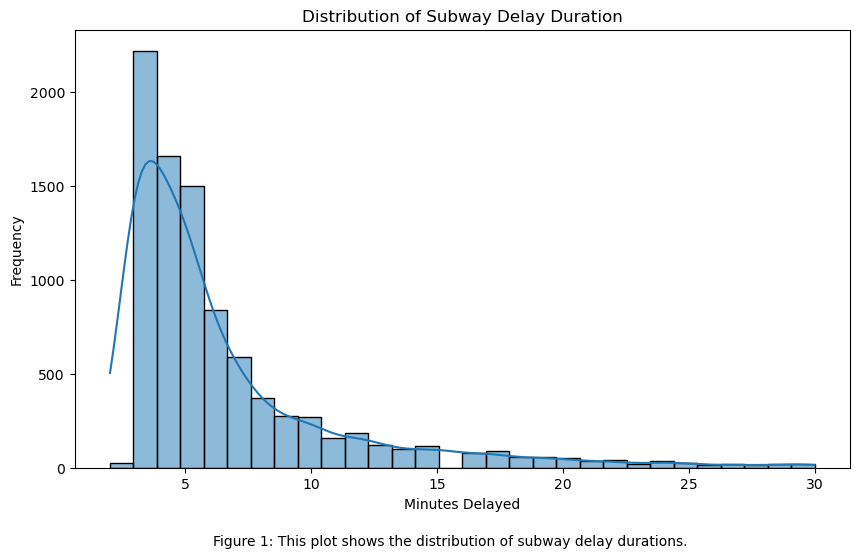

In [8]:
#| echo: false

# Distribution of Delay Duration
plt.figure(figsize=(10,6))
sns.histplot(merged_df['min_delay'], bins=30, kde=True)
plt.title("Distribution of Subway Delay Duration")
plt.xlabel("Minutes Delayed")
plt.ylabel("Frequency")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 1: This plot shows the distribution of subway delay durations.", 
            ha="center", fontsize=10, wrap=True)
plt.show()


In Figure 1,it appears the distribution of subway delay durations is left skewed with center around 5. This suggests most subway delays don't last longer than a few minutes.

To further explore the nature of subway delays, the most common delay codes were identified and visualized in a bar chart. 

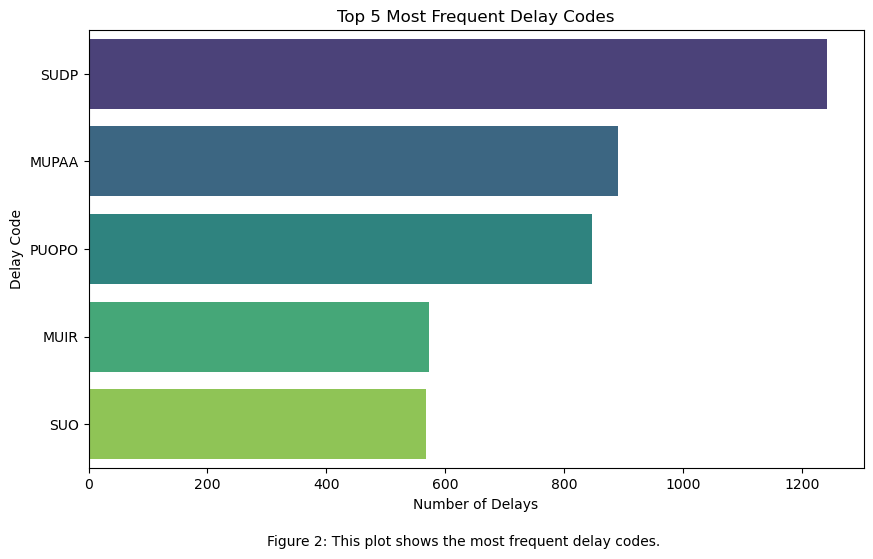

In [9]:
#| echo: false

# Get the top 5 most frequent delay codes
top_delay_codes = (
    merged_df['code']
    .value_counts()
    .nlargest(5)  # Select top 5
    .reset_index()
)
top_delay_codes.columns = ['code', 'count']

# Filter the original dataframe to only include the top 5 codes
filtered_df = merged_df[merged_df['code'].isin(top_delay_codes['code'])]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, y='code', order=top_delay_codes['code'], palette='viridis')

plt.title("Top 5 Most Frequent Delay Codes")
plt.xlabel("Number of Delays")
plt.ylabel("Delay Code")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 2: This plot shows the most frequent delay codes.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

From Figure 2, we see the most frequent delay codes in our data. According to the documentation provided in the TTC Subway Delay data (see reference), 'SUDP' is the delay code for 'Disorderly Patron', 'MUPAA' is the delay code for 'Passenger Assistance Alarm Activated - No Trouble Found', 'SUO' is the delay code for 'Passenger Other', 'PUOPO' is the delay code for 'OPTO (COMMS) Train Door Monitoring', and 'MUIR' is the delay code for 'Injured or ill Customer (On Train) - Medical Aid Refused'. All of these delay codes are possible when stations are busy and full of commuters.

Given that different subway lines may experience varying levels of congestion and maintenance challenges, a boxplot was used to compare the distribution of delays across lines. 

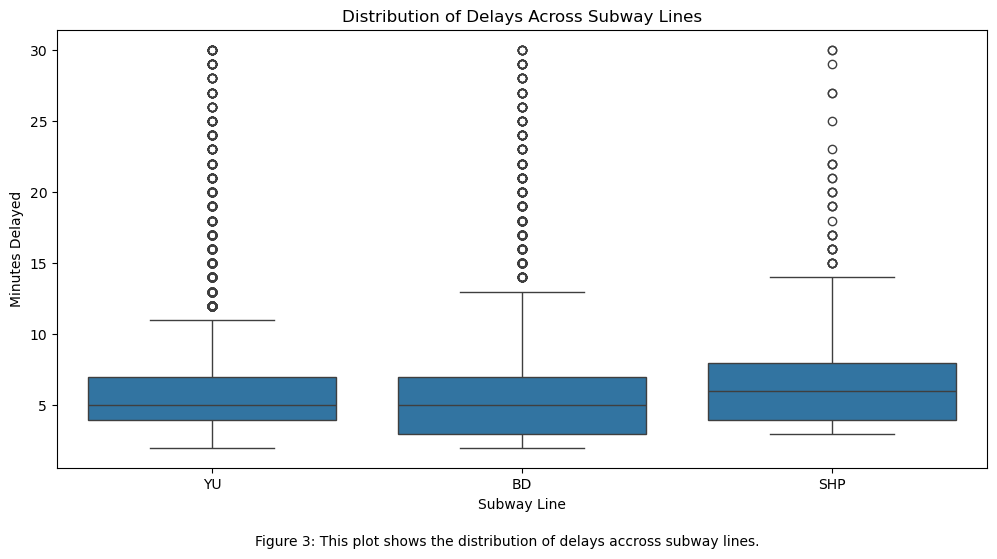

In [10]:
#| echo: false
# Delays by Line
plt.figure(figsize=(12,6))
sns.boxplot(x=merged_df['line'], y=merged_df['min_delay'])
plt.xticks()
plt.title("Distribution of Delays Across Subway Lines")
plt.xlabel("Subway Line")
plt.ylabel("Minutes Delayed")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 3: This plot shows the distribution of delays accross subway lines.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

Figure 3 suggests that Sheppard (SHP) line, is more prone to prolonged delays. Building on the subway line analysis, a bar chart was created to highlight the three most delay-prone stations per line.

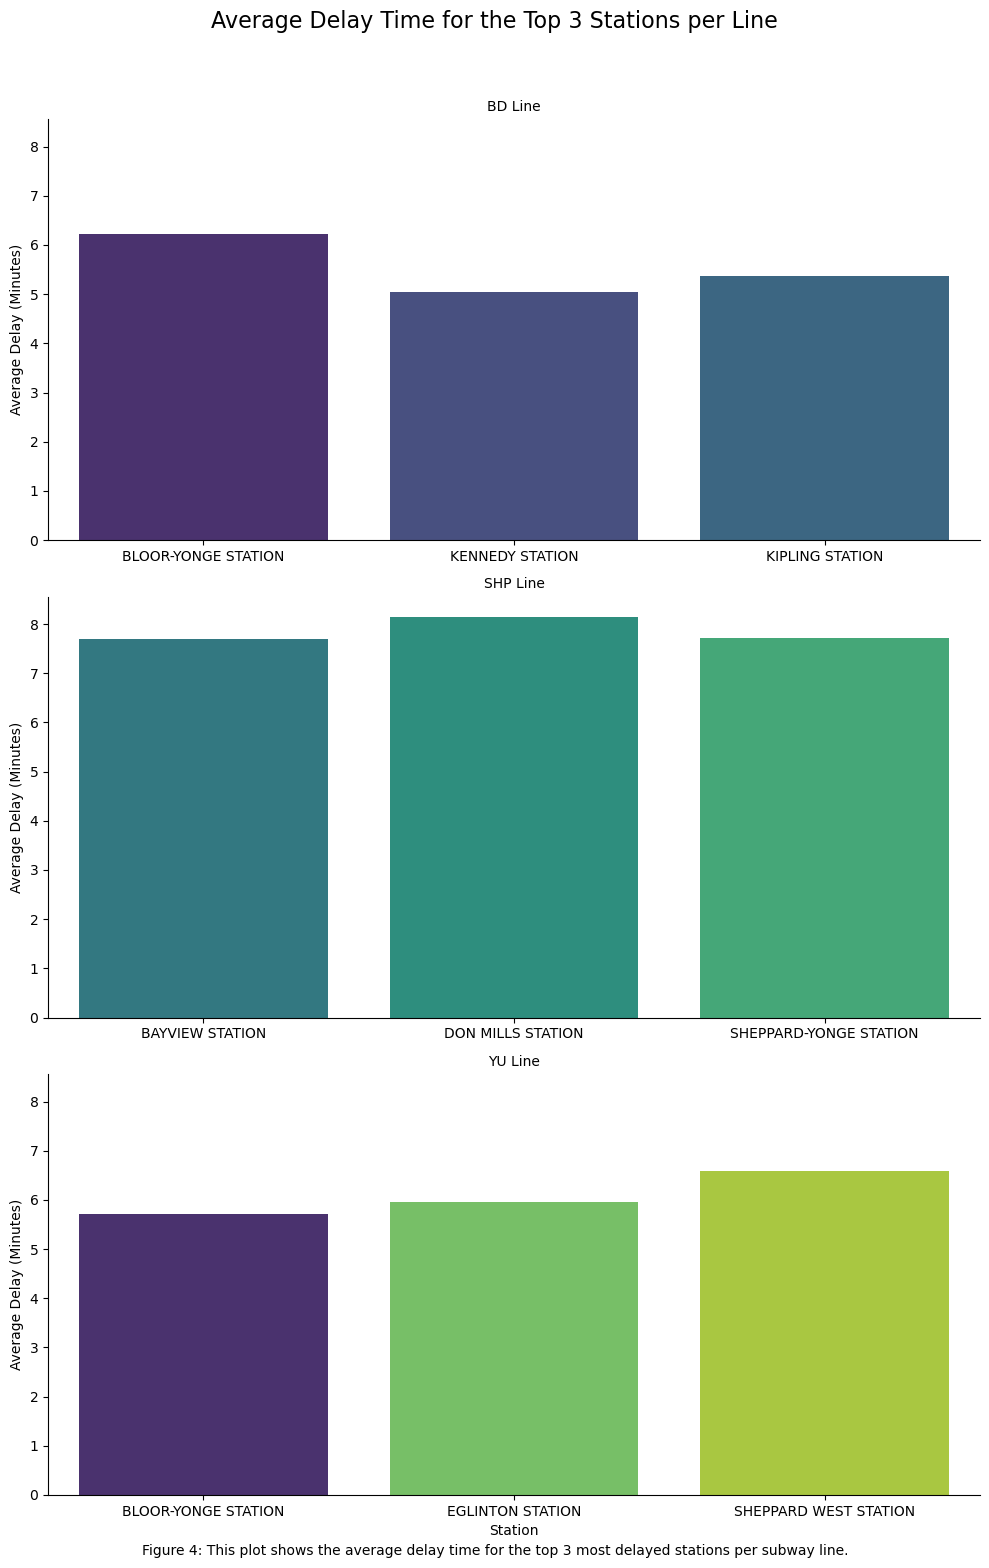

In [11]:
#| echo: false

# make 'station' str type (will reverse at the end)
merged_df["station"] = merged_df["station"].astype(str)

# Get the top 3 stations per line based on delay count (ensuring no duplicates across lines)
top_stations_per_line = (
    merged_df.groupby(['line', 'station'])
    .size()
    .reset_index(name="delay_count")
    .sort_values(['line', 'delay_count'], ascending=[True, False])  # Sort within each line
    .groupby('line')  # Group by line
    .head(3)  # Select top 3 stations per line
)

# Filter delay_df to include only the selected top stations
filtered_df = merged_df.merge(top_stations_per_line[['line', 'station']], on=['line', 'station'])

# Compute average delay for these stations per line
avg_delay_per_line = (
    filtered_df.groupby(['line', 'station'])['min_delay']
    .mean()
    .reset_index()
)

# Create Faceted Plot by Line with stations on X-axis and shared Y-axis
g = sns.catplot(
    data=avg_delay_per_line,
    x="station",  # Stations on X-axis
    y="min_delay",  # Average delay time on Y-axis
    col="line",  # Facet by subway line
    kind="bar",
    col_wrap=1,  # Adjust layout
    height=5,  # Make plot taller
    aspect=2,  # Widen subplots
    palette="viridis",
    sharey=True,  # Use shared Y-axis for uniformity
    sharex=False,  # Ensure correct spacing of station names
    legend=False  # Remove legend
)

g.set_axis_labels("Station", "Average Delay (Minutes)")
g.set_titles("{col_name} Line")
g.fig.suptitle("Average Delay Time for the Top 3 Stations per Line", y=1.05, fontsize=16)
    
# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.06)  # Moves the entire plot up
    
#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 4: This plot shows the average delay time for the top 3 most delayed stations per subway line.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

# return 'cleaned_station' to categorical type
merged_df["station"] = merged_df["station"].astype('category')

According to Figure 4, the most delayed stations on the Bloor-Danforth (BD) line are Bloor-Yonge, Kennedy, and Kipling stations. Further, the most delayed stations on the Sheppard (SHP) line are Bayview, Don Mills, and Sheppard-Yonge stations. Lastly, the most delated stations on the Yonge-University line are Bloor-Yone, Eglinton, and Sheppard West stations. All of these stations average a delay duration of over 5 minutes.

Another dimension of analysis involves train direction, as certain routes may be more susceptible to delays due to traffic flow or infrastructure constraints. A boxplot was used to compare the distribution of delays across train directions (northbound, southbound, eastbound, westbound), identifying whether specific bounds experience more disruptions.

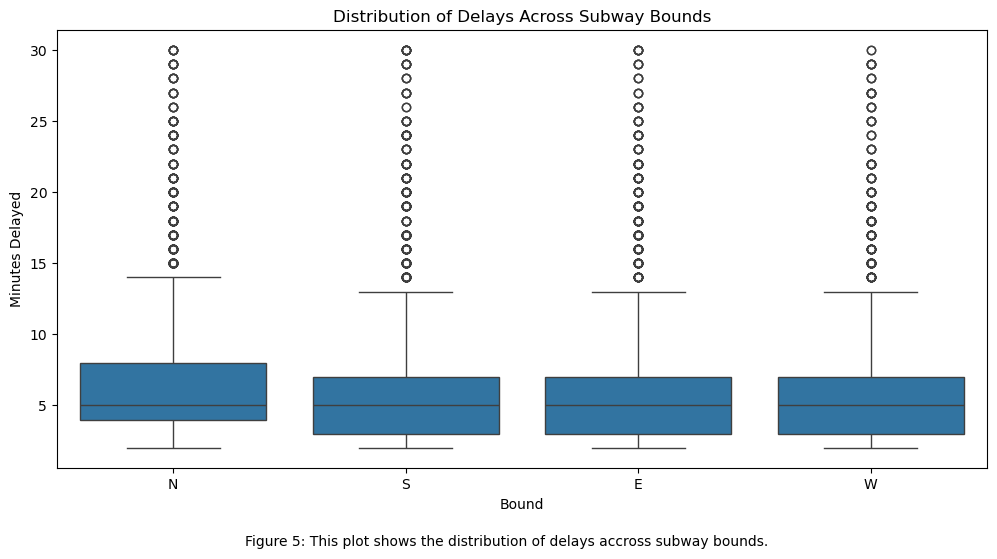

In [12]:
#| echo: false

# Delays by Bound
plt.figure(figsize=(12,6))
sns.boxplot(x=merged_df['bound'], y=merged_df['min_delay'])
plt.xticks()
plt.title("Distribution of Delays Across Subway Bounds")
plt.xlabel("Bound")
plt.ylabel("Minutes Delayed")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 5: This plot shows the distribution of delays accross subway bounds.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

In Figure 5, it appears northbound subways are more prone to longer disruptions with the other three having similar means and ranges.

Since subway usage fluctuates throughout the day, analyzing delays by hour can reveal peak periods of service disruption. A bar chart was used to visualize the number of delays occurring at each hour, helping to pinpoint when delays are most frequent. While delay frequency is important, understanding the average delay duration at different times of the day provides additional insight. A line plot was also generated to track fluctuations in average delay durations, highlighting whether peak travel hours correspond to longer delays.

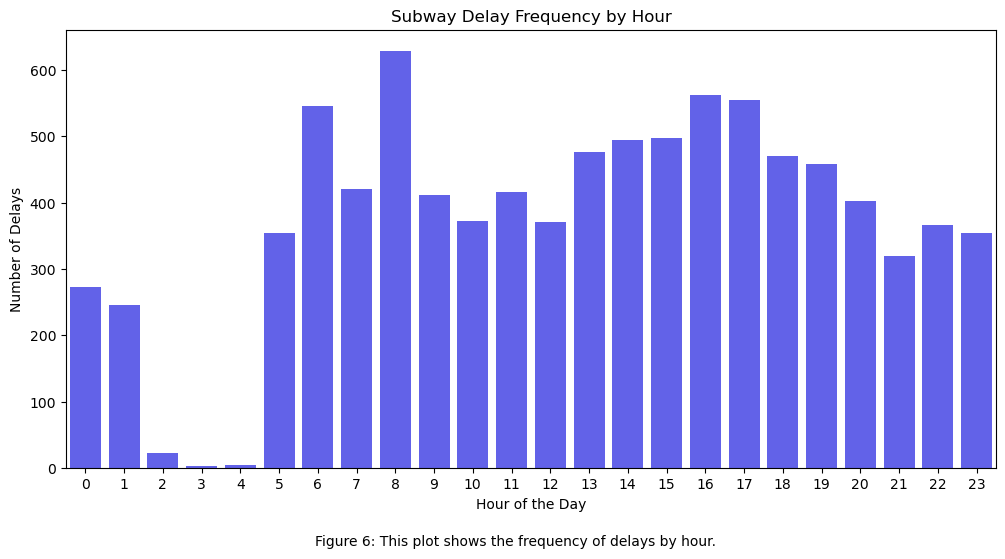

In [13]:
#| echo: false

# Aggregate delay count and average delay per hour
delay_by_hour = merged_df.groupby('hour').agg(
    delay_count=('min_delay', 'count'),
    avg_delay=('min_delay', 'mean')
).reset_index()

# Frequency of Delays per Hour
plt.figure(figsize=(12, 6))
sns.barplot(x=delay_by_hour['hour'], y=delay_by_hour['delay_count'], color='blue', alpha=0.7)
plt.title("Subway Delay Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Delays")
plt.xticks(range(0, 24))  # Ensure x-axis covers all hours (0-23)

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 6: This plot shows the frequency of delays by hour.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

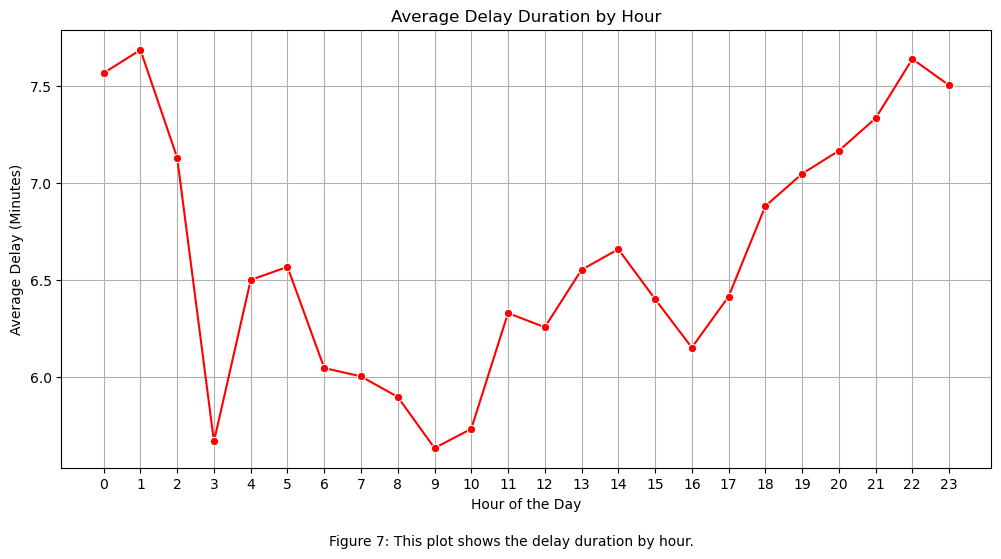

In [14]:
#| echo: false

# Average Delay Duration per Hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=delay_by_hour['hour'], y=delay_by_hour['avg_delay'], marker='o', color='red')
plt.title("Average Delay Duration by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(range(0, 24))  # Ensure x-axis covers all hours (0-23)
plt.grid(True)  # Add grid for readability

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 7: This plot shows the delay duration by hour.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

Based on Figures 6 and 7, subway delays are most frequent during morning and afternoon rush hours. However, the average delay duration is shorter during these periods compared to non-rush hours. This aligns with expectations, as the TTC likely prioritizes rapid resolution of delays during peak commuting times to minimize disruptions for the highest volume of passengers.

Beyond daily variations, subway performance may also differ across days of the week. A boxplot was used to visualize delay distributions for each day, allowing for the identification of patterns that may be linked to weekday rush hours or weekend maintenance work.

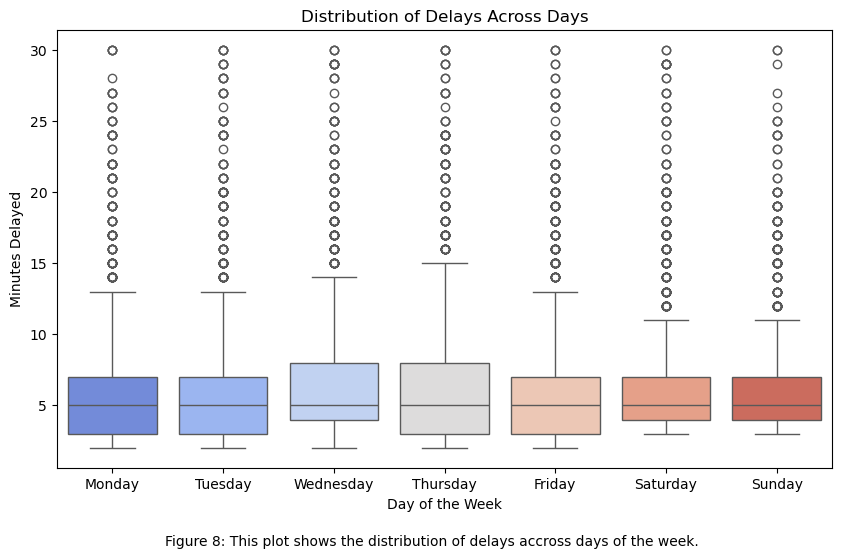

In [15]:
#| echo: false

# Define the correct order for days
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['day'], y=merged_df['min_delay'], order=day_order, palette="coolwarm")
plt.xticks()
plt.title("Distribution of Delays Across Days")
plt.xlabel("Day of the Week")
plt.ylabel("Minutes Delayed")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 8: This plot shows the distribution of delays accross days of the week.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

According to Figure 8, the average delay duration remains consistent across all days of the week, but the range of delays varies. Wednesdays and Thursdays show the widest range, while Saturdays and Sundays have the narrowest. This may be due to higher passenger volumes on weekends, potentially leading to longer but more consistent delays.

To further validate the observed trends, an ANOVA test was conducted to determine whether significant differences exist in delay durations across days, bounds, subway lines, and subway stations. 

In [16]:
#| echo: false

# Fit the ANOVA model
anova_model = smf.ols("min_delay ~ C(day) + C(bound) + C(line) + C(station)", data=merged_df).fit()

# Perform ANOVA test
anova_table = sm.stats.anova_lm(anova_model)

# Rename column headers
anova_table = anova_table.rename(columns={
    "df": "Degrees of Freedom", 
    "sum_sq": "Sum of Squares", 
    "mean_sq": "Mean Square", 
    "F": "F-Statistic", 
    "PR(>F)": "p-Value"
})

# Rename index names (variable names)
anova_table.index = anova_table.index.str.replace("C(", "").str.replace(")", "").str.replace("_", " ").str.title()

# Apply professional styling (matching summary table)
styled_anova = anova_table.style.set_caption("Table 2: ANOVA Results on the Impact of Subway Line on Delay Time") \
                               .format("{:.4f}") \
                               .set_table_styles([
                                   {"selector": "thead", "props": [("font-weight", "bold"), ("background-color", "#f4f4f4")]},
                                   {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]}
                               ]) \
                               .set_properties(**{"border": "1px solid black", "text-align": "center", "padding": "5px"})

# Display styled table
styled_anova


,Degrees of Freedom,Sum of Squares,Mean Square,F-Statistic,p-Value
Day,6.0000,170.9064,28.4844,1.2722,0.2663
Bound,3.0000,364.6444,121.5481,5.4288,0.0010
Line,2.0000,269.9193,134.9596,6.0278,0.0024
Station,69.0000,5561.1966,80.5971,3.5998,0.0000
Residual,8947.0000,200319.2190,22.3895,nan,nan


Based on the results of our ANOVA test in Table 2, bound, subway line, and station were found to significantly affect the duration of delay as they all three has p-values less than 0.05. On the other hand, the day of the week was not found to significantly affect the duration of delay as it had a p-value greater than 0.05.

To assess whether population density influences subway delays, a scatter plot was created to examine the correlation between service population size and delay duration. This analysis helps determine whether higher-density areas experience longer or more frequent delays.

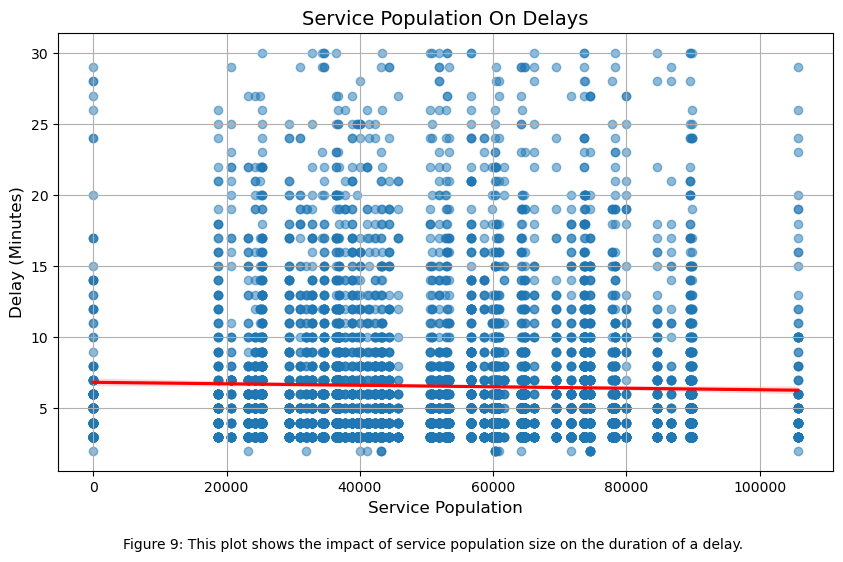

In [17]:
#| echo: false
plt.figure(figsize=(10, 6))
sns.regplot(x="service_population", y="min_delay", data=merged_df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Service Population On Delays", fontsize=14)
plt.xlabel("Service Population", fontsize=12)
plt.ylabel("Delay (Minutes)", fontsize=12)
plt.grid(True)

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 9: This plot shows the impact of service population size on the duration of a delay.", 
            ha="center", fontsize=10, wrap=True)

plt.show()


By Figure 9, the variation in delay duration appears consistent across both high- and low-density areas. However, delays seem less frequent in higher-density areas, as the data points are more concentrated on the left side of the plot. 

Given that transit performance is influenced by multiple factors, weather conditions play a crucial role. To quantify this impact, a correlation heatmap was generated to examine the relationships between subway delays, weather conditions, and service population.

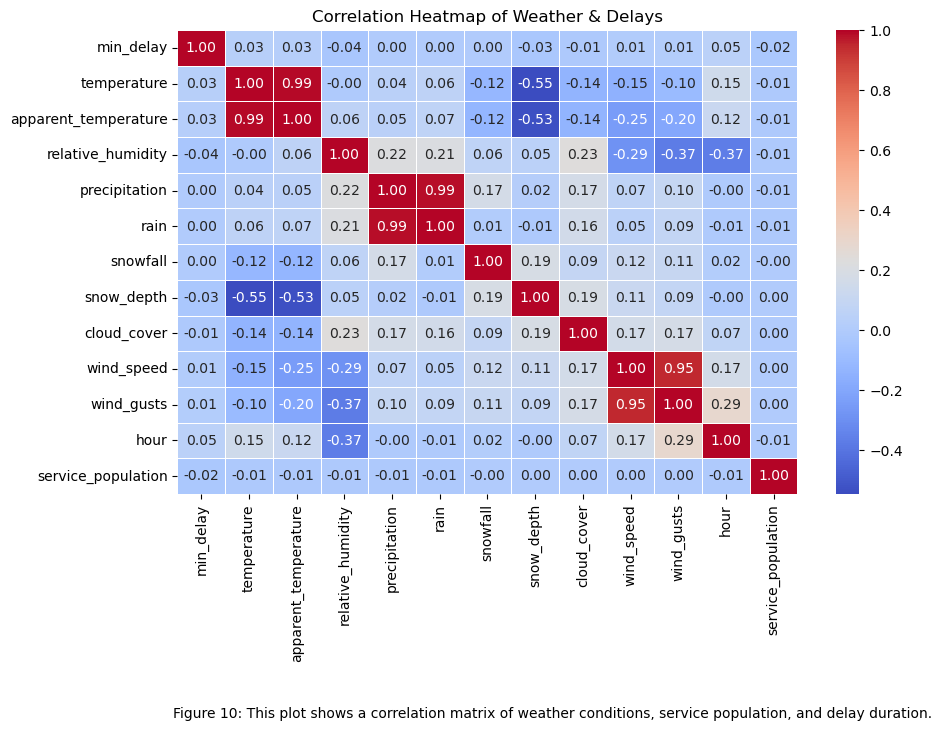

In [18]:
#| echo: false

# Compute correlation matrix 2
corr2_matrix = merged_df[["min_delay", "temperature", "apparent_temperature", "relative_humidity", 
                          "precipitation", "rain", "snowfall", "snow_depth", "cloud_cover", "wind_speed", 
                          "wind_gusts", "hour", "service_population"]].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr2_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Weather & Delays")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.3)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure 10: This plot shows a correlation matrix of weather conditions, service population, and delay duration.", 
            ha="center", fontsize=10, wrap=True)


plt.show()

The correlation heatmap, in Figure 10, reveals that weather conditions have minimal correlation with subway delay duration. Most weather variables show near-zero correlations with delay duration, while precipitation, rain, and snowfall show zero correlation, suggesting that weather may not be a strong predictor of delay length. Additionally, service population also has little correlation with delay duration, indicating that population density near stations does not significantly impact the length of delays. However, expected strong correlations are observed between related weather variables, such as temperature and apparent temperature, as well as precipitation and rain.

### Summary

This study analyzed subway delays within the Toronto Transit Commission (TTC) system, examining their occurrence and potential influences from weather conditions and population density. Using a merged dataset of transit delay reports, hourly weather data, and demographic information, key patterns in delay frequency and duration were explored. The findings indicate that delays are most frequent during morning and afternoon rush hours, but their durations tend to be shorter compared to non-peak times. Passenger-related incidents were the most common causes of delays, and the Sheppard (SHP) Line experienced the longest delays. Directional patterns also emerged, with northbound trains facing more frequent disruptions. However, weather conditions and service population density showed little correlation with delay duration, suggesting other operational factors play a larger role.

To build on these findings, the next phase will involve developing machine learning models to predict subway delays. Both classification and regression models will be explored, including decision trees, logistic regression, gradient boosting models. Classification models will be used to determine whether a delay will occur based on historical conditions, while regression models will estimate the expected duration of a delay. By implementing predictive modeling, this study aims to create a data-driven framework for anticipating delays, helping transit planners optimize scheduling and commuters make informed travel decisions. 

### References

- Open-meteo documentation: \url{https://open-meteo.com/en/docs/historical-weather-api}
- OpenStreetMap API documentation: \url{https://wiki.openstreetmap.org/wiki/API_v0.6}
- Toronto Neighbourhood Profiles: \url{https://open.toronto.ca/dataset/neighbourhood-profiles/}
- Toronto Neighbourhoods: \url{https://open.toronto.ca/dataset/neighbourhoods/}
- TTC Subway and Streetcar Map: \url{https://cdn.ttc.ca/-/media/Project/TTC/DevProto/Images/Home/Routes-and-Schedules/Landing-page-pdfs/TTC_SubwayStreetcarMap_2021-11.pdf?rev=909317034177450b8b09ba5b247e24bf}
- TTC Subway Delay Data: \url{https://open.toronto.ca/dataset/ttc-subway-delay-data/}
